In [21]:
from models import TDTSP, TemporalGraph, HopfieldNetwork
import numpy as np

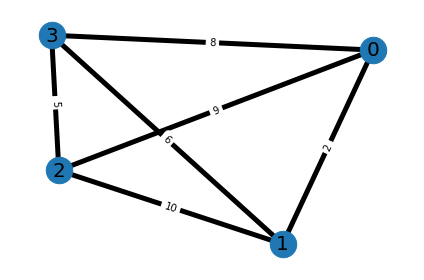

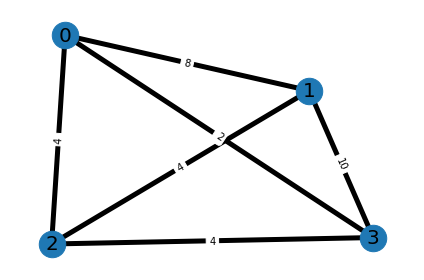

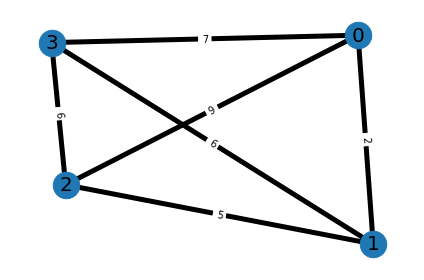

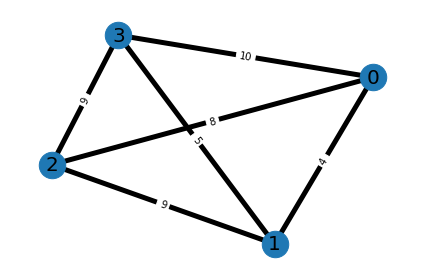

In [22]:
tg = TemporalGraph(4)
tg.draw_graphs()

In [23]:
tsp = TDTSP(tg,A=-500, B=-500, C=-200, D=-1)

In [24]:
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer

In [25]:
qubo = tsp.to_qubo()
print(qubo.prettyprint())

exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
sol = exact.solve(qubo)
print(sol)
print(tsp.interpret(sol.x))

Problem name: 

Minimize
  200*x0^2 + 900*x0*x1 + 400*x0*x10 + 408*x0*x11 + 900*x0*x12 + 408*x0*x13
  + 400*x0*x14 + 410*x0*x15 + 900*x0*x2 + 900*x0*x3 + 900*x0*x4 + 402*x0*x5
  + 400*x0*x6 + 404*x0*x7 + 900*x0*x8 + 409*x0*x9 + 200*x1^2 + 404*x1*x10
  + 400*x1*x11 + 408*x1*x12 + 900*x1*x13 + 402*x1*x14 + 400*x1*x15 + 900*x1*x2
  + 900*x1*x3 + 402*x1*x4 + 900*x1*x5 + 408*x1*x6 + 400*x1*x7 + 409*x1*x8
  + 900*x1*x9 + 200*x10^2 + 900*x10*x11 + 400*x10*x12 + 404*x10*x13
  + 900*x10*x14 + 406*x10*x15 + 200*x11^2 + 409*x11*x12 + 400*x11*x13
  + 406*x11*x14 + 900*x11*x15 + 200*x12^2 + 900*x12*x13 + 900*x12*x14
  + 900*x12*x15 + 200*x13^2 + 900*x13*x14 + 900*x13*x15 + 200*x14^2
  + 900*x14*x15 + 200*x15^2 + 900*x2*x10 + 409*x2*x11 + 400*x2*x12 + 402*x2*x13
  + 900*x2*x14 + 407*x2*x15 + 200*x2^2 + 900*x2*x3 + 400*x2*x4 + 408*x2*x5
  + 900*x2*x6 + 402*x2*x7 + 400*x2*x8 + 404*x2*x9 + 409*x3*x10 + 900*x3*x11
  + 410*x3*x12 + 400*x3*x13 + 407*x3*x14 + 900*x3*x15 + 200*x3^2 + 404*x3*x4
  + 400*x3*x5

In [26]:
# Encode Qubo formulation into Ising Model Hamiltonian
H, offset = qubo.to_ising()

In [27]:
# Solve on Ising model using NumPyMinimumEigensolver
algorithm_globals.random_seed = 10598
exact_mes = NumPyMinimumEigensolver()

In [28]:
exact = MinimumEigenOptimizer(exact_mes)  # using the exact classical numpy minimum eigen solver

In [29]:
exact_result = exact.solve(qubo)
print(exact_result.prettyprint())

solution = exact_result.x

tsp.interpret(solution)

objective function value: 16.0
variable values: x0=0.0, x1=0.0, x2=1.0, x3=0.0, x4=0.0, x5=0.0, x6=0.0, x7=1.0, x8=0.0, x9=1.0, x10=0.0, x11=0.0, x12=1.0, x13=0.0, x14=0.0, x15=0.0
status: SUCCESS


array([3., 2., 0., 1.])